In [134]:
import os
import sys
import time
import random
import warnings
import collections
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, HistGradientBoostingRegressor 
# from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.preprocessing import OneHotEncoder

sys.path.append('../src')
import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# configuration
use_cache = True
seed = random.randint(0, 100)

print(f'Seed: {seed}')

Seed: 19


In [4]:
query = f"select * from junk.ip_features_all;"
ip_features_all = cb_utils.sql_query_to_df(query, use_cache=use_cache)

Pulled query from cache


In [5]:
ip_features_all.shape

(1444147, 140)

In [6]:
member_key = cb_utils.sql_query_to_df(f"select * from junk.ip_member_key;", use_cache=use_cache)

Pulled query from cache


### Mark good member periods

eligible members on day of id and first day of post

iterate from first month to total_months - pre + post_period, create pre/post for member if elg

In [7]:
pre_months = 12
post_months = 6
pre_post_months = pre_months + post_months

In [8]:
months = sorted(ip_features_all.eom.unique())
n_months = len(months)
last_valid_pre_start = n_months - pre_post_months # 42
months[:3], months[-3:], n_months, last_valid_pre_start 

([datetime.date(2017, 1, 31),
  datetime.date(2017, 2, 28),
  datetime.date(2017, 3, 31)],
 [datetime.date(2021, 10, 31),
  datetime.date(2021, 11, 30),
  datetime.date(2021, 12, 31)],
 60,
 42)

In [9]:
# create bool column flags to easily query what batches this can be in
# pres = {f'pre_{i}': False for i, _ in enumerate(months) if i < last_valid_pre_start}
# posts = {f'post_{i}': False for i, _ in enumerate(months) if i < last_valid_pre_start}
flags = {f'{prefix}_{i}': False for prefix in ['pre', 'post', 'pre_post_elg'] for i in range(n_months) if i < last_valid_pre_start}
ip_features_all = ip_features_all.assign(**flags);

In [10]:
ifa = ip_features_all

In [11]:
# assign bool flags for each potential period
periods = []
for i in tqdm(range(last_valid_pre_start)):
    # Build date anchor points relative to start month
    pre_start = months[i]
    pre_end = months[i+11]
    # id_date = pre_end + relativedelta(days=1)
    
    post_start = None
    post_end = None
    if i + 17 < n_months:
        post_start = months[i+12]
        post_end = months[i+17]
        
    periods.append([i, pre_start, pre_end, post_start, post_end])

    # Determine elg members
    pre_elg = ifa.loc[(ifa.eom == pre_end) & (ifa.is_cb_eligible)].member_id.unique()
    post_elg = ifa.loc[(ifa.eom == post_start) & (ifa.is_cb_eligible)].member_id.unique()

    pre_post_elg_mems = np.intersect1d(pre_elg, post_elg)

    # Flag elg members for period i
    ifa.loc[(ifa.eom >= pre_start) & (ifa.eom <= pre_end) & (ifa.member_id.isin(pre_elg)), f'pre_{i}'] = True 
    ifa.loc[(ifa.eom >= post_start) & (ifa.eom <= post_end) & (ifa.member_id.isin(post_elg)), f'post_{i}'] = True 

    ifa.loc[(ifa.eom >= pre_start) & (ifa.eom <= post_end) & (ifa.member_id.isin(pre_post_elg_mems)), f'pre_post_elg_{i}'] = True 

100%|███████████████████████████████████████████| 42/42 [00:30<00:00,  1.38it/s]


In [12]:
periods_df = pd.DataFrame(periods, columns=['period', 'pre_start', 'pre_end', 'post_start', 'post_end'])

In [13]:
months_df = pd.DataFrame(months, columns=['eom'])

In [14]:
ifa.is_cb_eligible = ifa.is_cb_eligible.fillna(False)
ifa.is_unaligned = ifa.is_unaligned.fillna(False)
ifa = ifa.fillna(0)

In [15]:
ifa = ifa.assign(is_male=np.where(ifa.gender=='m',1,0))

In [16]:
# assign state
ifa = ifa.assign(state=ifa.mco_name.str.split(' ').apply(lambda x: x[1]).replace({'Centene': 'IA'}))

In [17]:
ifa.to_parquet('./data/member_periods_v7.parquet')

### Build features + targets

In [47]:
member_periods = pd.read_parquet('./data/member_periods_v7.parquet')

In [48]:
member_periods.to_csv('./data/member_periods_v7.csv', index=False)

In [19]:
member_periods.head()

,is_cb_eligible,mco_id,mco_name,eom,member_id,line_of_business_id,ggroup,is_unaligned,age,gender,cwmm,days_in_month,cpmm,rx_tc,other_tc,ip_tc,er_tc,out_tc,snf_tc,icf_tc,hh_tc,amb_tc,hsp_tc,pro_tc,spc_fac_tc,dme_tc,cls_tc,hha_tc,hcbs_attdpcs_tc,hcbs_other_tc,hcbs_support_house_tc,hcbs_adult_day_tc,ip_ddos_span,er_ddos_span,out_ddos_span,snf_ddos_span,icf_ddos_span,hh_ddos_span,amb_ddos_span,hsp_ddos_span,pro_ddos_span,spc_fac_ddos_span,dme_ddos_span,cls_ddos_span,hha_ddos_span,hcbs_attdpcs_ddos_span,hcbs_other_ddos_span,hcbs_support_house_ddos_span,hcbs_adult_day_ddos_span,other_ddos_span,ip_ddos,er_ddos,out_ddos,snf_ddos,icf_ddos,hh_ddos,amb_ddos,hsp_ddos,pro_ddos,spc_fac_ddos,dme_ddos,cls_ddos,hha_ddos,hcbs_attdpcs_ddos,hcbs_other_ddos,hcbs_support_house_ddos,hcbs_adult_day_ddos,other_ddos,hcbs_pers_ddos,hcbs_assist_tech_ddos,oxygen_ddos,hosp_bed_ddos,chf_ddos,heart_ddos,copd_ddos,pulmonar_ddos,cancer_ddos,ckd_ddos,esrd_ddos,lipidy_ddos,diab_ddos,alzh_ddos,demented_ddos,stroke_ddos,hyper_ddos,fall_ddos,trans_ddos,liver_ddos,hippy_ddos,depressed_ddos,psycho_ddos,druggy_ddos,boozy_ddos,paralyzed_ddos,mono_ddos,mono_dom_ddos,hemi_ddos,hemi_dom_ddos,para_ddos,quad_ddos,tbi_ddos,obese_ddos,pressure_ulcer_ddos,hemophilia_ddos,hcbs_pers_tc,hcbs_assist_tech_tc,oxygen_tc,hosp_bed_tc,chf_tc,heart_tc,copd_tc,pulmonar_tc,cancer_tc,ckd_tc,esrd_tc,lipidy_tc,diab_tc,alzh_tc,demented_tc,stroke_tc,hyper_tc,fall_tc,trans_tc,liver_tc,hippy_tc,depressed_tc,psycho_tc,druggy_tc,boozy_tc,paralyzed_tc,mono_tc,mono_dom_tc,hemi_tc,hemi_dom_tc,para_tc,quad_tc,tbi_tc,obese_tc,pressure_ulcer_tc,hemophilia_tc,pre_0,pre_1,pre_2,pre_3,pre_4,pre_5,pre_6,pre_7,pre_8,pre_9,pre_10,pre_11,pre_12,pre_13,pre_14,pre_15,pre_16,pre_17,pre_18,pre_19,pre_20,pre_21,pre_22,pre_23,pre_24,pre_25,pre_26,pre_27,pre_28,pre_29,pre_30,pre_31,pre_32,pre_33,pre_34,pre_35,pre_36,pre_37,pre_38,pre_39,pre_40,pre_41,post_0,post_1,post_2,post_3,post_4,post_5,post_6,post_7,post_8,post_9,post_10,post_11,post_12,post_13,post_14,post_15,post_16,post_17,post_18,post_19,post_20,post_21,post_22,post_23,post_24,post_25,post_26,post_27,post_28,post_29,post_30,post_31,post_32,post_33,post_34,post_35,post_36,post_37,post_38,post_39,post_40,post_41,pre_post_elg_0,pre_post_elg_1,pre_post_elg_2,pre_post_elg_3,pre_post_elg_4,pre_post_elg_5,pre_post_elg_6,pre_post_elg_7,pre_post_elg_8,pre_post_elg_9,pre_post_elg_10,pre_post_elg_11,pre_post_elg_12,pre_post_elg_13,pre_post_elg_14,pre_post_elg_15,pre_post_elg_16,pre_post_elg_17,pre_post_elg_18,pre_post_elg_19,pre_post_elg_20,pre_post_elg_21,pre_post_elg_22,pre_post_elg_23,pre_post_elg_24,pre_post_elg_25,pre_post_elg_26,pre_post_elg_27,pre_post_elg_28,pre_post_elg_29,pre_post_elg_30,pre_post_elg_31,pre_post_elg_32,pre_post_elg_33,pre_post_elg_34,pre_post_elg_35,pre_post_elg_36,pre_post_elg_37,pre_post_elg_38,pre_post_elg_39,pre_post_elg_40,pre_post_elg_41,is_male,state
0,False,1,Anthem TN,2018-03-31,21009,1,0.0,False,54,m,1,31,1.0,34.95,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,274.51,0,38.49,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [20]:
target_cols = ['ip_tc', 'er_tc', 'snf_tc', 'amb_tc']
##
tc_feats = [c for c in ifa.columns if '_tc' in c]
ddos_cols = [c for c in ifa.columns if '_ddos' in c]
# ddos_cols = ['ip_ddos', 'er_ddos', 'out_ddos', 'snf_ddos', 'icf_ddos', 'hh_ddos', 'amb_ddos', 'hsp_ddos', 'pro_ddos', 'spc_fac_ddos', 'dme_ddos', 'cls_ddos', 'hha_ddos']
top_level_feats = ['age', 'is_male', 'state', 'ggroup', 'line_of_business_id']

In [21]:
tc_dx_feats = [
 'rx_tc',
 'other_tc',
 'ip_tc',
 'er_tc',
 'out_tc',
 'snf_tc',
 'icf_tc',
 'hh_tc',
 'amb_tc',
 'hsp_tc',
 'pro_tc',
 'spc_fac_tc',
 'dme_tc',
 'cls_tc',
 'hha_tc',
# ----------- 
 'hcbs_attdpcs_tc',
 'hcbs_other_tc',
 'hcbs_support_house_tc',
 'hcbs_adult_day_tc',
 'hcbs_pers_tc',
 'hcbs_assist_tech_tc',
 'oxygen_tc',
 'hosp_bed_tc',
 'chf_tc',
 'heart_tc',
 'copd_tc',
 'pulmonar_tc',
 'cancer_tc',
 'ckd_tc',
 'esrd_tc',
 'lipidy_tc',
 'diab_tc',
 'alzh_tc',
 'demented_tc',
 'stroke_tc',
 'hyper_tc',
 'fall_tc',
 'trans_tc',
 'liver_tc',
 'hippy_tc',
 'depressed_tc',
 'psycho_tc',
 'druggy_tc',
 'boozy_tc',
 'paralyzed_tc',
 'mono_tc',
 'mono_dom_tc',
 'hemi_tc',
 'hemi_dom_tc',
 'para_tc',
 'quad_tc',
 'tbi_tc',
 'obese_tc',
 'pressure_ulcer_tc',
 'hemophilia_tc']

In [22]:
# def build_member_features(mdf): 
mcos = member_periods.mco_name.unique().tolist()
mco_cols = [f'is_{m.lower().replace(" ", "_")}' for m in mcos]
n_mcos = len(mcos)
def encode_mco(mco_str):
    one_hot = np.zeros(n_mcos, dtype=int)
    one_hot[mcos.index(mco_str)] = 1 
    return one_hot

In [23]:
lobs = member_periods.line_of_business_id.unique().tolist()
lob_cols = [f'is_lob_{l}' for l in lobs]
n_lobs = len(lobs)
def encode_lob(lob):
    one_hot = np.zeros(n_lobs, dtype=int)
    one_hot[lobs.index(lob)] = 1 
    return one_hot

In [24]:
groups = member_periods.ggroup.unique().tolist()
group_cols = [f'is_group_{l}' for l in groups]
n_groups = len(groups)
def encode_group(group):
    one_hot = np.zeros(n_groups, dtype=int)
    one_hot[groups.index(group)] = 1 
    return one_hot

In [25]:
states = member_periods.state.unique().tolist()
state_cols = [f'is_state_{l}' for l in states]
n_states = len(states)
def encode_state(state):
    one_hot = np.zeros(n_states, dtype=int)
    one_hot[states.index(state)] = 1 
    return one_hot

In [40]:
all_ddos_tc_cols_wide = [f'{c}_{i}' for i in range(pre_months) for c in ddos_cols + tc_dx_feats]

In [41]:
def build_member_features(mdf, months_range):
# mdf = member_periods.loc[(member_periods.pre_0) & (member_periods.pre_full_0) & (member_periods.member_id == 102)].sort_values('eom')
    # print(months_range)

    if len(mdf) == 0:
        return mdf
        
    demographic_data = mdf[top_level_feats + ['member_id']].iloc[-1]
    
    mdf = months_range.merge(mdf, on='eom', how='left')
    mdf = mdf.sort_values('eom')[ddos_cols + tc_dx_feats]
    mdf = mdf.fillna(0)
    
    ddos_data = mdf.to_numpy().reshape([1, -1])

    state_data = encode_state(demographic_data.state)
    lob_data = encode_lob(demographic_data.line_of_business_id)
    group_data = encode_group(demographic_data.ggroup)
    data = np.concatenate((ddos_data[0], state_data, lob_data, group_data, np.array([demographic_data.is_male, demographic_data.age, demographic_data.member_id])), axis=0, dtype=float)
    cols = all_ddos_tc_cols_wide + state_cols + lob_cols + group_cols + ['is_male', 'age', 'member_id']

    return pd.DataFrame([data], columns=cols)

In [42]:
# d = pd.DataFrame([
#     [1, 'B', 'C'],
#     [2, 'd', 'e'],
#     [3, 'f', 'g'],
# ], columns=['id', 'tc', 'ddos'])
# # tcols = [f'{c}_{i}' for i in range(3) for c in ]
# dcols = [f'{c}_{i}' for i in range(3) for c in ['id'] + ['tc', 'ddos']]
# dd = d.to_numpy().reshape([1, -1])
# # tdcols = [sub for sub in zip(tcols, dcols)] 
# # tdcols
# pd.DataFrame(dd, columns=dcols)
    
# mdf = member_periods.loc[(member_periods.pre_0) & (member_periods.pre_full_0 == False) & (member_periods.member_id == 26)].sort_values('eom')

In [43]:
def build_member_targets(mdf):
    if len(mdf) == 0:
        return pd.DataFrame([], columns=['member_id', 'target'])
    tc = mdf[target_cols].sum().sum()
#     pmpm = tc / mdf.cpmm.sum()
    return pd.DataFrame([[mdf.iloc[0].member_id, tc]], columns=['member_id', 'target'])

In [44]:
def build_targets(post_df):
    return post_df.groupby('member_id', as_index=False).apply(build_member_targets)

In [45]:
def build_features(pre_df, months_range):
    return pre_df.groupby('member_id', as_index=False).apply(lambda x: build_member_features(x, months_range))

In [124]:
# NOTE: Takes forever, moved to python script for multi threading
# build features and targets for each period
# period_dfs = []
# for i in tqdm(range(last_valid_pre_start)):
#     elg = member_periods.loc[member_periods[f'pre_post_elg_{i}']] 
#     pre = elg.loc[elg[f'pre_{i}']] 

#     post = elg.loc[elg[f'post_{i}']] 
#     x = build_features(pre, months_df.loc[i:i+11])
#     # if i < 42:
#     y = build_targets(post)
#     final = x.merge(y, how='left', left_on='member_id', right_on='member_id').assign(period=i)
#     # else:
#         # final = x.assign(period=i)
#     period_dfs.append(final)

In [ ]:
master_df = pd.concat(period_dfs)
master_df.shape

In [36]:
# master_df.to_parquet('./data/master_df.parquet')
# master_df.to_parquet('./data/master_ddos_df.parquet')
master_df.to_parquet('./data/master_wide_df_v7.parquet')

### Train/Val/Test split
Avoid any leakage by doing the splits at the member level

In [52]:
# master_df = pd.read_parquet('./data/master_df.parquet')
# master_df = pd.read_parquet('./data/master_ddos_df.parquet')
master_df = pd.read_parquet('./data/master_wide_v7.parquet')
# master_df = master_df.loc[master_df.period > 24]
# make dtype str for these categorical features
# master_df.ggroup = master_df.ggroup.astype(str)
# master_df.line_of_business_id = master_df.line_of_business_id.astype(str)

In [53]:
master_df.head()

,ip_ddos_span_0,er_ddos_span_0,out_ddos_span_0,snf_ddos_span_0,icf_ddos_span_0,hh_ddos_span_0,amb_ddos_span_0,hsp_ddos_span_0,pro_ddos_span_0,spc_fac_ddos_span_0,dme_ddos_span_0,cls_ddos_span_0,hha_ddos_span_0,hcbs_attdpcs_ddos_span_0,hcbs_other_ddos_span_0,hcbs_support_house_ddos_span_0,hcbs_adult_day_ddos_span_0,other_ddos_span_0,ip_ddos_0,er_ddos_0,out_ddos_0,snf_ddos_0,icf_ddos_0,hh_ddos_0,amb_ddos_0,hsp_ddos_0,pro_ddos_0,spc_fac_ddos_0,dme_ddos_0,cls_ddos_0,hha_ddos_0,hcbs_attdpcs_ddos_0,hcbs_other_ddos_0,hcbs_support_house_ddos_0,hcbs_adult_day_ddos_0,other_ddos_0,hcbs_pers_ddos_0,hcbs_assist_tech_ddos_0,oxygen_ddos_0,hosp_bed_ddos_0,chf_ddos_0,heart_ddos_0,copd_ddos_0,pulmonar_ddos_0,cancer_ddos_0,ckd_ddos_0,esrd_ddos_0,lipidy_ddos_0,diab_ddos_0,alzh_ddos_0,demented_ddos_0,stroke_ddos_0,hyper_ddos_0,fall_ddos_0,trans_ddos_0,liver_ddos_0,hippy_ddos_0,depressed_ddos_0,psycho_ddos_0,druggy_ddos_0,boozy_ddos_0,paralyzed_ddos_0,mono_ddos_0,mono_dom_ddos_0,hemi_ddos_0,hemi_dom_ddos_0,para_ddos_0,quad_ddos_0,tbi_ddos_0,obese_ddos_0,pressure_ulcer_ddos_0,hemophilia_ddos_0,rx_tc_0,other_tc_0,ip_tc_0,er_tc_0,out_tc_0,snf_tc_0,icf_tc_0,hh_tc_0,amb_tc_0,hsp_tc_0,pro_tc_0,spc_fac_tc_0,dme_tc_0,cls_tc_0,hha_tc_0,hcbs_attdpcs_tc_0,hcbs_other_tc_0,hcbs_support_house_tc_0,hcbs_adult_day_tc_0,hcbs_pers_tc_0,hcbs_assist_tech_tc_0,oxygen_tc_0,hosp_bed_tc_0,chf_tc_0,heart_tc_0,copd_tc_0,pulmonar_tc_0,cancer_tc_0,ckd_tc_0,esrd_tc_0,lipidy_tc_0,diab_tc_0,alzh_tc_0,demented_tc_0,stroke_tc_0,hyper_tc_0,fall_tc_0,trans_tc_0,liver_tc_0,hippy_tc_0,depressed_tc_0,psycho_tc_0,druggy_tc_0,boozy_tc_0,paralyzed_tc_0,mono_tc_0,mono_dom_tc_0,hemi_tc_0,hemi_dom_tc_0,para_tc_0,quad_tc_0,tbi_tc_0,obese_tc_0,pressure_ulcer_tc_0,hemophilia_tc_0,ip_ddos_span_1,er_ddos_span_1,out_ddos_span_1,snf_ddos_span_1,icf_ddos_span_1,hh_ddos_span_1,amb_ddos_span_1,hsp_ddos_span_1,pro_ddos_span_1,spc_fac_ddos_span_1,dme_ddos_span_1,cls_ddos_span_1,hha_ddos_span_1,hcbs_attdpcs_ddos_span_1,hcbs_other_ddos_span_1,hcbs_support_house_ddos_span_1,hcbs_adult_day_ddos_span_1,other_ddos_span_1,ip_ddos_1,er_ddos_1,out_ddos_1,snf_ddos_1,icf_ddos_1,hh_ddos_1,amb_ddos_1,hsp_ddos_1,pro_ddos_1,spc_fac_ddos_1,dme_ddos_1,cls_ddos_1,hha_ddos_1,hcbs_attdpcs_ddos_1,hcbs_other_ddos_1,hcbs_support_house_ddos_1,hcbs_adult_day_ddos_1,other_ddos_1,hcbs_pers_ddos_1,hcbs_assist_tech_ddos_1,oxygen_ddos_1,hosp_bed_ddos_1,chf_ddos_1,heart_ddos_1,copd_ddos_1,pulmonar_ddos_1,cancer_ddos_1,ckd_ddos_1,esrd_ddos_1,lipidy_ddos_1,diab_ddos_1,alzh_ddos_1,demented_ddos_1,stroke_ddos_1,hyper_ddos_1,fall_ddos_1,trans_ddos_1,liver_ddos_1,hippy_ddos_1,depressed_ddos_1,psycho_ddos_1,druggy_ddos_1,boozy_ddos_1,paralyzed_ddos_1,mono_ddos_1,mono_dom_ddos_1,hemi_ddos_1,hemi_dom_ddos_1,para_ddos_1,quad_ddos_1,tbi_ddos_1,obese_ddos_1,pressure_ulcer_ddos_1,hemophilia_ddos_1,rx_tc_1,other_tc_1,ip_tc_1,er_tc_1,out_tc_1,snf_tc_1,icf_tc_1,hh_tc_1,amb_tc_1,hsp_tc_1,pro_tc_1,spc_fac_tc_1,dme_tc_1,cls_tc_1,hha_tc_1,hcbs_attdpcs_tc_1,hcbs_other_tc_1,hcbs_support_house_tc_1,hcbs_adult_day_tc_1,hcbs_pers_tc_1,hcbs_assist_tech_tc_1,oxygen_tc_1,hosp_bed_tc_1,chf_tc_1,heart_tc_1,copd_tc_1,pulmonar_tc_1,cancer_tc_1,ckd_tc_1,esrd_tc_1,lipidy_tc_1,diab_tc_1,alzh_tc_1,demented_tc_1,stroke_tc_1,hyper_tc_1,fall_tc_1,trans_tc_1,liver_tc_1,hippy_tc_1,depressed_tc_1,psycho_tc_1,druggy_tc_1,boozy_tc_1,paralyzed_tc_1,mono_tc_1,mono_dom_tc_1,hemi_tc_1,hemi_dom_tc_1,para_tc_1,quad_tc_1,...,hosp_bed_ddos_10,chf_ddos_10,heart_ddos_10,copd_ddos_10,pulmonar_ddos_10,cancer_ddos_10,ckd_ddos_10,esrd_ddos_10,lipidy_ddos_10,diab_ddos_10,alzh_ddos_10,demented_ddos_10,stroke_ddos_10,hyper_ddos_10,fall_ddos_10,trans_ddos_10,liver_ddos_10,hippy_ddos_10,depressed_ddos_10,psycho_ddos_10,druggy_ddos_10,boozy_ddos_10,paralyzed_ddos_10,mono_ddos_10,mono_dom_ddos_10,hemi_ddos_10,hemi_dom_ddos_10,para_ddos_10,quad_ddos_10,tbi_ddos_10,obese_ddos_10,pressure_ulcer_ddos_10,hemophilia_ddos_10,rx_tc_10,other_tc_10,ip_tc_10,er_tc_10,out_tc_10,snf_tc_10,icf_tc_10,hh_tc_10,am

### Train Test Split

In [135]:
def train_val_test_split(df, file_suffix='', save_member_id=False, sm_format=True, pct_train=.8, pct_val=.15, upload=True, return_wo_saving=False):
    member_ids = df.member_id.unique()
    n_members = len(member_ids)

    train_n = int(n_members * .8)
    val_n = int(n_members * .15)
    test_n = n_members - train_n - val_n

    np.random.shuffle(member_ids)

    train_mems, val_mems, test_mems = np.split(member_ids, [train_n, train_n + val_n])
    assert train_mems.shape[0] == train_n
    assert val_mems.shape[0] == val_n
    assert test_mems.shape[0] == test_n

    training_df = df.loc[df.member_id.isin(train_mems)]
    val_df = df.loc[df.member_id.isin(val_mems)]
    test_df = df.loc[df.member_id.isin(test_mems)]
    
    if return_wo_saving:
        return training_df, val_df, test_df
    
    if not save_member_id:
        training_df = training_df.drop(columns=['member_id'])
        val_df = val_df.drop(columns=['member_id'])
        test_df = test_df.drop(columns=['member_id'])
    
    if sm_format:
        cols = ['target'] + [c for c in training_df.columns if c != 'target'] # sm target always first
        training_df[cols].to_csv(f'data/training_df_{file_suffix}.csv', header=False, index=False)
        val_df[cols].to_csv(f'data/val_df_{file_suffix}.csv', header=False, index=False)
        test_df[cols].to_csv(f'data/test_df_{file_suffix}.csv', header=False, index=False)
        
        with open(f'data/columns_{file_suffix}.txt', 'w') as f:
            f.write(','.join(cols))
            
        if upload:
            
            cb_utils.upload_file_to_s3(
    f'data/training_df_{file_suffix}.csv',
    'cb-analytics-us-east-2-prd',
    'sagemaker/data/' + file_suffix + '/train.csv')
            
            cb_utils.upload_file_to_s3(
    f'data/val_df_{file_suffix}.csv',
    'cb-analytics-us-east-2-prd',
    'sagemaker/data/' + file_suffix + '/val.csv')
            
            cb_utils.upload_file_to_s3(
    f'data/test_df_{file_suffix}.csv',
    'cb-analytics-us-east-2-prd',
    'sagemaker/data/' + file_suffix + '/test.csv')
            
            cb_utils.upload_file_to_s3(
    f'data/columns_{file_suffix}.txt',
    'cb-analytics-us-east-2-prd',
    'sagemaker/data/' + file_suffix + '/columns.txt')
                    
                    
    else:
        training_df.to_parquet(f'data/training_df_{file_suffix}.parquet')
        val_df.to_parquet(f'data/val_df_{file_suffix}.parquet')
        test_df.to_parquet(f'data/test_df_{file_suffix}.parquet')
        

### Build Column types

In [247]:
service_types =  ['ip', 'er', 'out', 'snf', 'icf', 'hh', 'amb', 'hsp', 'pro', 'spc_fac', 'dme', 'cls', 'hha']
ddos_service_type_cols = [f'{st}_ddos' for st in service_types]
tc_service_type_cols = [f'{st}_tc' for st in service_types]
demographic_cols = [
 'is_state_TN',
 'is_state_FL',
 'is_state_TX',
 'is_state_KS',
 'is_state_IA',
 'is_lob_1',
 'is_lob_3',
 'is_lob_2',
 'is_lob_8',
 'is_group_0.0',
 'is_group_3.0',
 'is_group_2.0',
 'is_group_1.0',
 'is_group_-1.0',
 'is_group_5.0',
 'is_group_6.0',
 'is_group_4.0',
 'is_group_8.0',
 'is_group_14.0',
 'is_group_16.0',
 'is_group_7.0',
 'is_group_11.0',
 'is_group_15.0',
 'is_group_20.0',
 'is_group_12.0',
 'is_group_13.0',
 'is_group_9.0',
 'is_group_21.0',
 'is_group_18.0',
 'is_group_10.0',
 'is_male',
 'age',
#  'member_id',
#  'target',
#  'period'
]
disease_cols = ['oxygen' , 'hosp_bed' , 'chf' , 'heart' , 'copd' , 'pulmonar' , 'cancer' , 'ckd' , 'esrd' , 'lipidy' , 'diab' , 'alzh' , 'demented' , 'stroke' , 'hyper' , 'fall' , 'trans' , 'liver' , 'hippy' , 'depressed' , 'psycho' , 'druggy' , 'boozy' , 'paralyzed' , 'mono' , 'mono_dom' , 'hemi' , 'hemi_dom' , 'para' , 'quad' , 'tbi' , 'obese' , 'pressure_ulcer' , 'hemophilia' ]
ddos_disease_cols = [f'{d}_ddos' for d in disease_cols]

### Build Yearly DDOS service_types + Demographics

In [195]:
def build_yearly_stddos_dem(df):
    feature_cols = ddos_service_type_cols + demographic_cols
    n_features = len(feature_cols)
    n_columns = n_features + 2 # member_id + target
    st_matrix = np.zeros((df.shape[0], n_columns))

    for i in range(len(ddos_service_type_cols)):
        st = ddos_service_type_cols[i]
        st_cols = [f'{st}_{i}' for i in range(12)] 
        st_matrix[:, i] = df[st_cols].sum(axis=1)
    #     print(i)

    st_matrix[:, len(ddos_service_type_cols):] = df[demographic_cols + ['member_id', 'target']]
    d = pd.DataFrame(st_matrix, columns=feature_cols + ['member_id', 'target'])
    return d

In [122]:
d = build_yearly_stddos_dem(master_df)
train_val_test_split(d, 'yearly_st_ddos_dem')

### Build Yearly TC service_types + Demographics

In [158]:
def build_yearly_sttc_dem(df):
    feature_cols = tc_service_type_cols + demographic_cols
    n_features = len(feature_cols)
    n_columns = n_features + 2 # member_id + target
    st_matrix = np.zeros((df.shape[0], n_columns))

    for i in range(len(tc_service_type_cols)):
        st = tc_service_type_cols[i]
        st_cols = [f'{st}_{i}' for i in range(12)] 
        st_matrix[:, i] = df[st_cols].sum(axis=1)

    st_matrix[:, len(tc_service_type_cols):] = df[demographic_cols + ['member_id', 'target']]
    d = pd.DataFrame(st_matrix, columns=feature_cols + ['member_id', 'target'])
    return d

In [159]:
d = build_yearly_sttc_dem(master_df)
# display(d)
train_val_test_split(d, 'yearly_st_tc_dem')

,ip_tc,er_tc,out_tc,snf_tc,icf_tc,hh_tc,amb_tc,hsp_tc,pro_tc,spc_fac_tc,dme_tc,cls_tc,hha_tc,is_state_TN,is_state_FL,is_state_TX,is_state_KS,is_state_IA,is_lob_1,is_lob_3,is_lob_2,is_lob_8,is_group_0.0,is_group_3.0,is_group_2.0,is_group_1.0,is_group_-1.0,is_group_5.0,is_group_6.0,is_group_4.0,is_group_8.0,is_group_14.0,is_group_16.0,is_group_7.0,is_group_11.0,is_group_15.0,is_group_20.0,is_group_12.0,is_group_13.0,is_group_9.0,is_group_21.0,is_group_18.0,is_group_10.0,is_male,age,member_id,target
0,11429.58,336.61,1037.42,0.0,0.0,630.0,0.0,0.0,2566.48,0.0,109.97,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,1.0,0.00
1,0.00,0.00,0.00,0.0,0.0,2720.0,0.0,0.0,145.03,0.0,1247.58,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,2.0,253.86
2,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,84.47,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,60.0,3.0,0.00
3,0.00,0.00,889.13,0.0,0.0,0.0,0.0,0.0,918.73,0.0,2421.17,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,41.0,6.0,0.00
4,0.00,0.00,201.35,0.0,0.0,1730.4,0.0,0.0,850.00,0.0,12653.46,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,55.0,8.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974569,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,39.0,317223.0,0.00
974570,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,317224.0,0.00
974571,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,39.0,317226.0,0.00
974572,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,317401.0,0.00


###  Month over month (MOM) DDOS service_types + Dem

In [137]:
def build_mom_stddos_dem(df):
    mom_ddos_service_type_cols = [f'{c}_{i}' for c in ddos_service_type_cols for i in range(12)]
    feature_cols = mom_ddos_service_type_cols + demographic_cols
    n_features = len(feature_cols)
    n_columns = n_features + 2 # member_id + target
    st_matrix = np.zeros((df.shape[0], n_columns))

    st_matrix[:, :len(mom_ddos_service_type_cols)] = df[mom_ddos_service_type_cols]
    st_matrix[:, len(mom_ddos_service_type_cols):] = df[demographic_cols + ['member_id', 'target']]
    d = pd.DataFrame(st_matrix, columns=feature_cols + ['member_id', 'target'])
    return d

d = build_mom_stddos_dem(master_df)
train_val_test_split(d, 'mom_stddos_dem')

###  Month over month (MOM) DDOS service_types + Dem

In [157]:
def build_mom_sttc_dem(df):
    mom_tc_service_type_cols = [f'{c}_{i}' for c in tc_service_type_cols for i in range(12)]
    feature_cols = mom_tc_service_type_cols + demographic_cols
    n_features = len(feature_cols)
    n_columns = n_features + 2 # member_id + target
    st_matrix = np.zeros((df.shape[0], n_columns))

    st_matrix[:, :len(mom_tc_service_type_cols)] = df[mom_tc_service_type_cols]
    st_matrix[:, len(mom_tc_service_type_cols):] = df[demographic_cols + ['member_id', 'target']]
    d = pd.DataFrame(st_matrix, columns=feature_cols + ['member_id', 'target'])
    return d

d = build_mom_sttc_dem(master_df)
train_val_test_split(d, 'mom_sttc_dem')

### Yearly dx ddos  + Dem

In [254]:
def build_yearly_dxddos_dem(df):
    feature_cols = ddos_disease_cols + demographic_cols
    n_features = len(feature_cols)
    n_columns = n_features + 2 # member_id + target
    st_matrix = np.zeros((df.shape[0], n_columns))

    for i in range(len(ddos_disease_cols)):
        st = ddos_disease_cols[i]
        st_cols = [f'{st}_{i}' for i in range(12)] 
        st_matrix[:, i] = df[st_cols].sum(axis=1)

    st_matrix[:, len(ddos_disease_cols) :] = df[demographic_cols + ['member_id', 'target']]
    d = pd.DataFrame(st_matrix, columns=feature_cols + ['member_id', 'target'])
    return d


# train_val_test_split(d, 'mom_stdxddos_dem')

### Yearly st DDOS + dx ddos  + Dem

In [248]:
def build_yearly_stdxddos_dem(df):
    feature_cols = ddos_disease_cols + ddos_service_type_cols + demographic_cols
    n_features = len(feature_cols)
    n_columns = n_features + 2 # member_id + target
    st_matrix = np.zeros((df.shape[0], n_columns))

    for i in range(len(ddos_disease_cols)):
        st = ddos_disease_cols[i]
        st_cols = [f'{st}_{i}' for i in range(12)] 
        st_matrix[:, i] = df[st_cols].sum(axis=1)
        
    for i in range(len(ddos_service_type_cols)):
        st = ddos_service_type_cols[i]
        st_cols = [f'{st}_{i}' for i in range(12)] 
        st_matrix[:, i+len(ddos_disease_cols)] = df[st_cols].sum(axis=1)
    #     print(i)

    st_matrix[:, len(ddos_disease_cols) + len(ddos_service_type_cols):] = df[demographic_cols + ['member_id', 'target']]
    d = pd.DataFrame(st_matrix, columns=feature_cols + ['member_id', 'target'])
    return d


d = build_yearly_stdxddos_dem(master_df)
# train_val_test_split(d, 'mom_stdxddos_dem')

In [273]:
# d = build_yearly_stdxddos_dem(master_df)
d = build_mom_stddos_dem(master_df)
train, val, test =  train_val_test_split(d, return_wo_saving=True)

In [274]:
x_cols = [c for c in train.columns if c not in demographic_cols and c not in ['member_id', 'target', 'period']]
# x_cols = [c for c in training_df.columns if c not in ['member_id', 'target', 'period'] + cat_feats]
x = train[x_cols]
y = train.target

val_x = val[x_cols]
val_y = val.target

In [275]:
model = HistGradientBoostingRegressor()
model.fit(x,y)

HistGradientBoostingRegressor()

In [276]:
model.score(x,y), model.score(val_x, val_y), np.abs(model.predict(x) - y).mean(), np.abs(model.predict(val_x) - val_y).mean()

(0.18643560141378623,
 0.15199559503416782,
 5121.090756175323,
 5228.361069414098)

In [271]:
model.score(x,y), model.score(val_x, val_y), np.abs(model.predict(x) - y).mean(), np.abs(model.predict(val_x) - val_y).mean()

(0.2551315718511029, 0.1445812220164867, 5094.079651190368, 5188.350164402817)

In [267]:
model.score(x,y), model.score(val_x, val_y), np.abs(model.predict(x) - y).mean(), np.abs(model.predict(val_x) - val_y).mean()

(0.21877944769801916, 0.1278922458251236, 5137.433726515899, 5347.41287564859)

In [263]:
model.score(x,y), model.score(val_x, val_y), np.abs(model.predict(x) - y).mean(), np.abs(model.predict(val_x) - val_y).mean()

(0.28412489255934625,
 0.12250041302611858,
 5023.30081260009,
 5230.9339440919075)

In [272]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, val_x, val_y, n_repeats=10, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{x.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

ip_ddos 0.069 +/- 0.001
snf_ddos0.024 +/- 0.001
er_ddos 0.021 +/- 0.001
amb_ddos0.015 +/- 0.001
hyper_ddos0.007 +/- 0.001
ckd_ddos0.006 +/- 0.000
pro_ddos0.005 +/- 0.000
esrd_ddos0.005 +/- 0.000
dme_ddos0.005 +/- 0.000
chf_ddos0.004 +/- 0.000
diab_ddos0.003 +/- 0.000
pressure_ulcer_ddos0.003 +/- 0.000
oxygen_ddos0.002 +/- 0.000
hh_ddos 0.002 +/- 0.000
obese_ddos0.001 +/- 0.000
quad_ddos0.001 +/- 0.000
lipidy_ddos0.001 +/- 0.000
depressed_ddos0.001 +/- 0.000
copd_ddos0.001 +/- 0.000
hsp_ddos0.000 +/- 0.000
stroke_ddos0.000 +/- 0.000
icf_ddos0.000 +/- 0.000
mono_ddos0.000 +/- 0.000
hippy_ddos0.000 +/- 0.000
hha_ddos0.000 +/- 0.000
para_ddos0.000 +/- 0.000


In [ ]:
MOM DDOS service_types and dx + Dem
5...8 same but for TC

Maybe a combo TC + DDOS
Span?

### Normalize/encode features if needed
not needed for trees, most linear models will do it for you if you pass the param

In [203]:
def mae(model, x, y):
    preds = model.predict(x)
    return np.abs(preds-y).mean()

### Tune mom ddos st + dem

In [214]:
d = build_mom_stddos_dem(master_df)
# d = build_mom_sttc_dem(master_df)
# d = build_yearly_sttc_dem(master_df)
# d = build_yearly_stddos_dem(master_df)
train, val, test =  train_val_test_split(d, return_wo_saving=True)
train.head()

,ip_ddos_0,ip_ddos_1,ip_ddos_2,ip_ddos_3,ip_ddos_4,ip_ddos_5,ip_ddos_6,ip_ddos_7,ip_ddos_8,ip_ddos_9,ip_ddos_10,ip_ddos_11,er_ddos_0,er_ddos_1,er_ddos_2,er_ddos_3,er_ddos_4,er_ddos_5,er_ddos_6,er_ddos_7,er_ddos_8,er_ddos_9,er_ddos_10,er_ddos_11,out_ddos_0,out_ddos_1,out_ddos_2,out_ddos_3,out_ddos_4,out_ddos_5,out_ddos_6,out_ddos_7,out_ddos_8,out_ddos_9,out_ddos_10,out_ddos_11,snf_ddos_0,snf_ddos_1,snf_ddos_2,snf_ddos_3,snf_ddos_4,snf_ddos_5,snf_ddos_6,snf_ddos_7,snf_ddos_8,snf_ddos_9,snf_ddos_10,snf_ddos_11,icf_ddos_0,icf_ddos_1,icf_ddos_2,icf_ddos_3,icf_ddos_4,icf_ddos_5,icf_ddos_6,icf_ddos_7,icf_ddos_8,icf_ddos_9,icf_ddos_10,icf_ddos_11,hh_ddos_0,hh_ddos_1,hh_ddos_2,hh_ddos_3,hh_ddos_4,hh_ddos_5,hh_ddos_6,hh_ddos_7,hh_ddos_8,hh_ddos_9,hh_ddos_10,hh_ddos_11,amb_ddos_0,amb_ddos_1,amb_ddos_2,amb_ddos_3,amb_ddos_4,amb_ddos_5,amb_ddos_6,amb_ddos_7,amb_ddos_8,amb_ddos_9,amb_ddos_10,amb_ddos_11,hsp_ddos_0,hsp_ddos_1,hsp_ddos_2,hsp_ddos_3,hsp_ddos_4,hsp_ddos_5,hsp_ddos_6,hsp_ddos_7,hsp_ddos_8,hsp_ddos_9,hsp_ddos_10,hsp_ddos_11,pro_ddos_0,pro_ddos_1,pro_ddos_2,pro_ddos_3,pro_ddos_4,pro_ddos_5,pro_ddos_6,pro_ddos_7,pro_ddos_8,pro_ddos_9,pro_ddos_10,pro_ddos_11,spc_fac_ddos_0,spc_fac_ddos_1,spc_fac_ddos_2,spc_fac_ddos_3,spc_fac_ddos_4,spc_fac_ddos_5,spc_fac_ddos_6,spc_fac_ddos_7,spc_fac_ddos_8,spc_fac_ddos_9,spc_fac_ddos_10,spc_fac_ddos_11,dme_ddos_0,dme_ddos_1,dme_ddos_2,dme_ddos_3,dme_ddos_4,dme_ddos_5,dme_ddos_6,dme_ddos_7,dme_ddos_8,dme_ddos_9,dme_ddos_10,dme_ddos_11,cls_ddos_0,cls_ddos_1,cls_ddos_2,cls_ddos_3,cls_ddos_4,cls_ddos_5,cls_ddos_6,cls_ddos_7,cls_ddos_8,cls_ddos_9,cls_ddos_10,cls_ddos_11,hha_ddos_0,hha_ddos_1,hha_ddos_2,hha_ddos_3,hha_ddos_4,hha_ddos_5,hha_ddos_6,hha_ddos_7,hha_ddos_8,hha_ddos_9,hha_ddos_10,hha_ddos_11,is_state_TN,is_state_FL,is_state_TX,is_state_KS,is_state_IA,is_lob_1,is_lob_3,is_lob_2,is_lob_8,is_group_0.0,is_group_3.0,is_group_2.0,is_group_1.0,is_group_-1.0,is_group_5.0,is_group_6.0,is_group_4.0,is_group_8.0,is_group_14.0,is_group_16.0,is_group_7.0,is_group_11.0,is_group_15.0,is_group_20.0,is_group_12.0,is_group_13.0,is_group_9.0,is_group_21.0,is_group_18.0,is_group_10.0,is_male,age,member_id,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,6.0,1.0,0.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,1.0,0.00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,3.0,5.0,3.0,4.0,5.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,2.0,253.86
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [215]:
x_cols = [c for c in train.columns if c not in ['member_id', 'target', 'period']]
# x_cols = [c for c in training_df.columns if c not in ['member_id', 'target', 'period'] + cat_feats]
x = train[x_cols]
y = train.target

val_x = val[x_cols]
val_y = val.target

Things to tune
- l2_regularization=1
- learning_rate
- min_samples_leaf
- max_iter=100,
- max_depth=40,

- tune('learning_rate', np.arange(0.01, 0.1, .01))
- min_samples_leaf_results = tune('min_samples_leaf', [50, 60, 70, 100])

In [ ]:
# determine number of iterations

In [236]:
def tune(param, values):
    val_scores = []
    train_scores = []
    val_mae = []
    train_mae = []
    for v in tqdm(values):
        kw = {param: v}
        histr = HistGradientBoostingRegressor(max_iter=100, **kw)
        histr.fit(x, y)
        val_scores.append(histr.score(val_x, val_y))
        train_scores.append(histr.score(x, y))
        train_mae.append(np.abs(histr.predict(x) - y).mean())
        val_mae.append(np.abs(histr.predict(val_x) - val_y).mean())
        
#         print(f'Val: {val_scores[-1]}. Train: {train_scores[-1]}')

    results = pd.DataFrame(zip(values, train_scores, val_scores, train_mae, val_mae), columns=[param, 'Train Score', 'Val Score', 'Train MAE', 'Val MAE'])
    scores_tall = results.melt(id_vars=[param], value_vars=['Train Score', 'Val Score'], value_name='score')
    mae_tall = results.melt(id_vars=[param], value_vars=['Train MAE', 'Val MAE'], value_name='mae')

    display(sns.relplot(data=scores_tall, x=param, y='score', hue='variable', kind='line'))
    display(sns.relplot(data=mae_tall, x=param, y='mae', hue='variable', kind='line'))
    return results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:38<00:00, 26.37s/it]


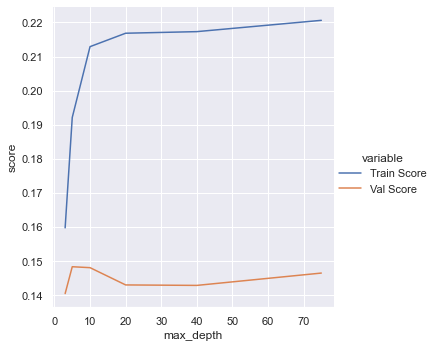

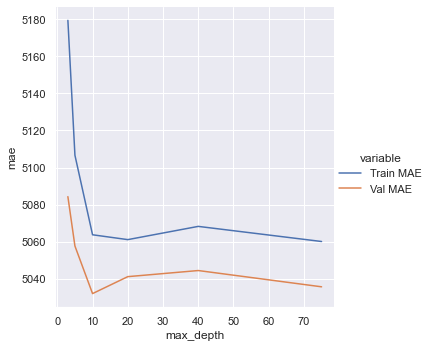

In [237]:
max_depth = tune('max_depth', [3, 5, 10, 20, 40, 75])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:32<00:00, 26.57s/it]


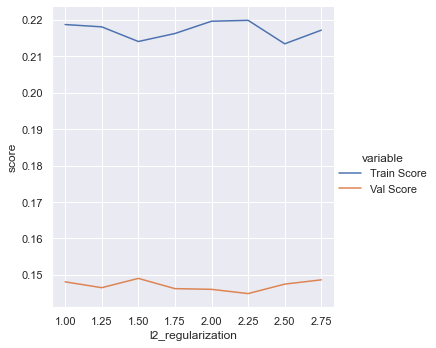

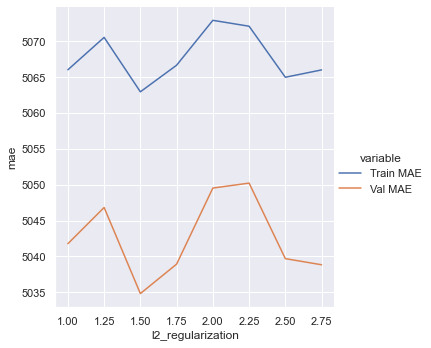

In [238]:
l2 = tune('l2_regularization', np.arange(1., 3, .25))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.16s/it]


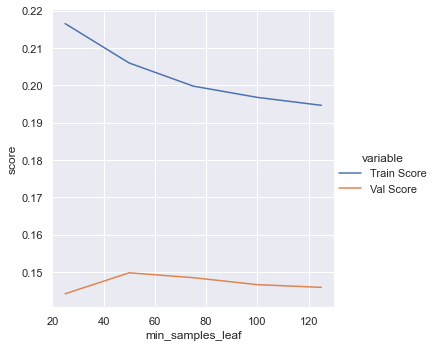

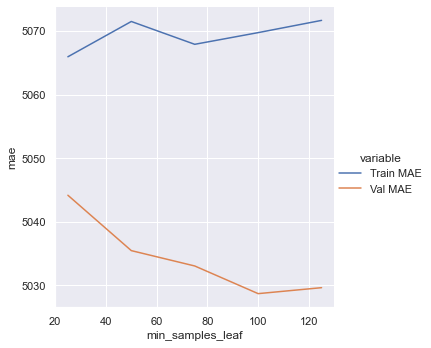

In [239]:
min_samples_leaf_results = tune('min_samples_leaf', [25, 50, 75, 100, 125])

In [245]:
model = HistGradientBoostingRegressor(max_iter=100,
                                      min_samples_leaf=100,
                                      max_depth=5,
                                      l2_regularization=1.5)
model.fit(x,y)
model.score(x,y), model.score(val_x, val_y), np.abs(model.predict(x) - y).mean(), np.abs(model.predict(val_x) - val_y).mean()

(0.18122931419516897,
 0.14683974575787928,
 5113.608879307343,
 5049.843585637472)

In [218]:
# mom tc
model.fit(x,y)
model.score(x,y), model.score(val_x, val_y)

(0.21904162723764553, 0.1481667553618542)

In [213]:
# mom tc
model.fit(x,y)
model.score(x,y), model.score(val_x, val_y)

(0.23388693599340005, 0.14629374380116977)

In [208]:
# mom ddos
model.fit(x,y)
model.score(x,y), model.score(val_x, val_y)

(0.20807819579764086, 0.19421145915828764)

In [182]:
# yearly tc
model.fit(x,y)
model.score(x,y), model.score(val_x, val_y)

(0.2464590751043405, 0.11053022101846388)

In [200]:
# yearly ddos
model.fit(x,y)
model.score(x,y), model.score(val_x, val_y)

(0.22763021490896707, 0.11621640305275516)

In [201]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, val_x, val_y, n_repeats=10, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{x.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

In [192]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{x.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

ip_tc   0.121 +/- 0.003
snf_tc  0.037 +/- 0.002
er_tc   0.013 +/- 0.001
amb_tc  0.011 +/- 0.001
is_state_TX0.011 +/- 0.001
age     0.011 +/- 0.002
is_state_IA0.009 +/- 0.002
pro_tc  0.003 +/- 0.001
is_group_4.00.001 +/- 0.000
out_tc  0.001 +/- 0.000
hha_tc  0.001 +/- 0.000
is_state_FL0.000 +/- 0.000
is_group_5.00.000 +/- 0.000
hsp_tc  0.000 +/- 0.000


HistGradientBoostingRegressor()

0.15887789722234957

0.1498660151246637

0.21283156440840134

0.16217545996362737

In [46]:
ridge = Ridge(alpha=1, normalize=True)

In [47]:
ridge.fit(x, y)

/Users/bp/miniconda3/envs/da/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


Ridge(alpha=1, normalize=True)

In [48]:
ridge.score(x,y)

0.1484452975138304

In [49]:
val_x = val_df[x_cols]
val_y = val_df.target
ridge.score(val_x,val_y)

0.14251581427374604

In [51]:
histr = HistGradientBoostingRegressor()
histr.fit(x, y)

HistGradientBoostingRegressor()

In [52]:
histr.score(x, y)

0.2574800220536849

In [53]:
histr.score(val_x, val_y)

0.15944613612012726

In [ ]:
val_df.head()

In [ ]:
train_preds = histr.predict(x)
val_preds = histr.predict(val_x)

In [ ]:
train_w_preds = training_df.assign(pred=train_preds, sample='train').merge(periods_df, on='period')
val_w_preds = val_df.assign(pred=val_preds, sample='validation').merge(periods_df, on='period')

In [ ]:
out_cols = ['member_id', 'sample', 'target', 'pred', 'period', 'pre_start', 'pre_end', 'post_start', 'post_end']

In [ ]:
pd.concat([train_w_preds[out_cols], val_w_preds[out_cols]]).to_csv('hgbr_12_mom_ddos.csv', index=False)

### Feature importance

In [50]:
sorted(zip(ridge.coef_, x.columns))

[(-744.3443821147873, 'is_group_14.0'),
 (-535.2269592142112, 'is_group_16.0'),
 (-493.3166853500218, 'is_group_7.0'),
 (-471.47293173355564, 'is_group_9.0'),
 (-425.8762239209822, 'is_group_18.0'),
 (-423.87695606167006, 'is_lob_1'),
 (-422.8530853784313, 'is_group_12.0'),
 (-373.8904176673686, 'mono_dom_tc_10'),
 (-352.7727375992785, 'is_group_4.0'),
 (-335.504459064428, 'is_state_IA'),
 (-297.4944238340344, 'is_group_6.0'),
 (-250.43629316514293, 'is_group_13.0'),
 (-237.3540535612524, 'hemi_dom_tc_2'),
 (-225.71405298750608, 'hyper_tc_1'),
 (-215.39051765550442, 'hosp_bed_tc_0'),
 (-214.33157838140224, 'oxygen_tc_4'),
 (-205.83750833139766, 'is_state_TN'),
 (-196.95483690942024, 'is_group_10.0'),
 (-188.90866167043063, 'demented_tc_9'),
 (-171.30118835783256, 'amb_ddos_8'),
 (-167.57347068886622, 'is_group_5.0'),
 (-160.96992437933153, 'stroke_tc_5'),
 (-158.02840512552805, 'hh_ddos_4'),
 (-128.33080691147197, 'is_group_15.0'),
 (-117.70336295260445, 'hemi_tc_6'),
 (-67.34123048952

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
result = permutation_importance(histr, val_x, val_y, n_repeats=10,random_state=0, n_jobs=-1)

In [ ]:
sorted(zip(result.importances_mean, val_x.columns))

### Write datasets for sagemaker

In [62]:
export_cols = ['target'] + [c for c in training_df.columns if c not in ['member_id', 'target', 'period']]
training_df[export_cols].head()

,target,ip_ddos_0,er_ddos_0,out_ddos_0,snf_ddos_0,icf_ddos_0,hh_ddos_0,amb_ddos_0,hsp_ddos_0,pro_ddos_0,spc_fac_ddos_0,dme_ddos_0,cls_ddos_0,hha_ddos_0,ip_ddos_1,er_ddos_1,out_ddos_1,snf_ddos_1,icf_ddos_1,hh_ddos_1,amb_ddos_1,hsp_ddos_1,pro_ddos_1,spc_fac_ddos_1,dme_ddos_1,cls_ddos_1,hha_ddos_1,ip_ddos_2,er_ddos_2,out_ddos_2,snf_ddos_2,icf_ddos_2,hh_ddos_2,amb_ddos_2,hsp_ddos_2,pro_ddos_2,spc_fac_ddos_2,dme_ddos_2,cls_ddos_2,hha_ddos_2,ip_ddos_3,er_ddos_3,out_ddos_3,snf_ddos_3,icf_ddos_3,hh_ddos_3,amb_ddos_3,hsp_ddos_3,pro_ddos_3,spc_fac_ddos_3,dme_ddos_3,cls_ddos_3,hha_ddos_3,ip_ddos_4,er_ddos_4,out_ddos_4,snf_ddos_4,icf_ddos_4,hh_ddos_4,amb_ddos_4,hsp_ddos_4,pro_ddos_4,spc_fac_ddos_4,dme_ddos_4,cls_ddos_4,hha_ddos_4,ip_ddos_5,er_ddos_5,out_ddos_5,snf_ddos_5,icf_ddos_5,hh_ddos_5,amb_ddos_5,hsp_ddos_5,pro_ddos_5,spc_fac_ddos_5,dme_ddos_5,cls_ddos_5,hha_ddos_5,ip_ddos_6,er_ddos_6,out_ddos_6,snf_ddos_6,icf_ddos_6,hh_ddos_6,amb_ddos_6,hsp_ddos_6,pro_ddos_6,spc_fac_ddos_6,dme_ddos_6,cls_ddos_6,hha_ddos_6,ip_ddos_7,er_ddos_7,out_ddos_7,snf_ddos_7,icf_ddos_7,hh_ddos_7,amb_ddos_7,hsp_ddos_7,pro_ddos_7,spc_fac_ddos_7,dme_ddos_7,cls_ddos_7,hha_ddos_7,ip_ddos_8,er_ddos_8,out_ddos_8,snf_ddos_8,icf_ddos_8,hh_ddos_8,amb_ddos_8,hsp_ddos_8,pro_ddos_8,spc_fac_ddos_8,dme_ddos_8,cls_ddos_8,hha_ddos_8,ip_ddos_9,er_ddos_9,out_ddos_9,snf_ddos_9,icf_ddos_9,hh_ddos_9,amb_ddos_9,hsp_ddos_9,pro_ddos_9,spc_fac_ddos_9,dme_ddos_9,cls_ddos_9,hha_ddos_9,ip_ddos_10,er_ddos_10,out_ddos_10,snf_ddos_10,icf_ddos_10,hh_ddos_10,amb_ddos_10,hsp_ddos_10,pro_ddos_10,spc_fac_ddos_10,dme_ddos_10,cls_ddos_10,hha_ddos_10,ip_ddos_11,er_ddos_11,out_ddos_11,snf_ddos_11,icf_ddos_11,hh_ddos_11,amb_ddos_11,hsp_ddos_11,pro_ddos_11,spc_fac_ddos_11,dme_ddos_11,cls_ddos_11,hha_ddos_11,hcbs_attdpcs_tc_0,hcbs_other_tc_0,hcbs_support_house_tc_0,hcbs_adult_day_tc_0,hcbs_pers_tc_0,hcbs_assist_tech_tc_0,oxygen_tc_0,hosp_bed_tc_0,chf_tc_0,heart_tc_0,copd_tc_0,pulmonar_tc_0,cancer_tc_0,ckd_tc_0,esrd_tc_0,lipidy_tc_0,diab_tc_0,alzh_tc_0,demented_tc_0,stroke_tc_0,hyper_tc_0,fall_tc_0,trans_tc_0,liver_tc_0,hippy_tc_0,depressed_tc_0,psycho_tc_0,druggy_tc_0,boozy_tc_0,paralyzed_tc_0,mono_tc_0,mono_dom_tc_0,hemi_tc_0,hemi_dom_tc_0,para_tc_0,quad_tc_0,tbi_tc_0,obese_tc_0,pressure_ulcer_tc_0,hemophilia_tc_0,hcbs_attdpcs_tc_1,hcbs_other_tc_1,hcbs_support_house_tc_1,hcbs_adult_day_tc_1,hcbs_pers_tc_1,hcbs_assist_tech_tc_1,oxygen_tc_1,hosp_bed_tc_1,chf_tc_1,heart_tc_1,copd_tc_1,pulmonar_tc_1,cancer_tc_1,ckd_tc_1,esrd_tc_1,lipidy_tc_1,diab_tc_1,alzh_tc_1,demented_tc_1,stroke_tc_1,hyper_tc_1,fall_tc_1,trans_tc_1,liver_tc_1,hippy_tc_1,depressed_tc_1,psycho_tc_1,druggy_tc_1,boozy_tc_1,paralyzed_tc_1,mono_tc_1,mono_dom_tc_1,hemi_tc_1,hemi_dom_tc_1,para_tc_1,quad_tc_1,tbi_tc_1,obese_tc_1,pressure_ulcer_tc_1,hemophilia_tc_1,hcbs_attdpcs_tc_2,hcbs_other_tc_2,hcbs_support_house_tc_2,hcbs_adult_day_tc_2,hcbs_pers_tc_2,hcbs_assist_tech_tc_2,oxygen_tc_2,hosp_bed_tc_2,chf_tc_2,heart_tc_2,copd_tc_2,pulmonar_tc_2,cancer_tc_2,...,trans_tc_6,liver_tc_6,hippy_tc_6,depressed_tc_6,psycho_tc_6,druggy_tc_6,boozy_tc_6,paralyzed_tc_6,mono_tc_6,mono_dom_tc_6,hemi_tc_6,hemi_dom_tc_6,para_tc_6,quad_tc_6,tbi_tc_6,obese_tc_6,pressure_ulcer_tc_6,hemophilia_tc_6,hcbs_attdpcs_tc_7,hcbs_other_tc_7,hcbs_support_house_tc_7,hcbs_adult_day_tc_7,hcbs_pers_tc_7,hcbs_assist_tech_tc_7,oxygen_tc_7,hosp_bed_tc_7,chf_tc_7,heart_tc_7,copd_tc_7,pulmonar_tc_7,cancer_tc_7,ckd_tc_7,esrd_tc_7,lipidy_tc_7,diab_tc_7,alzh_tc_7,demented_tc_7,stroke_tc_7,hyper_tc_7,fall_tc_7,trans_tc_7,liver_tc_7,hippy_tc_7,depressed_tc_7,psycho_tc_7,druggy_tc_7,boozy_tc_7,paralyzed_tc_7,mono_tc_7,mono_dom_tc_7,hemi_tc_7,hemi_dom_tc_7,para_tc_7,quad_tc_7,tbi_tc_7,obese_tc_7,pressure_ulcer_tc_7,hemophilia_tc_7,hcbs_attdpcs_tc_8,hcbs_other_tc_8,hcbs_support_house_tc_8,hcbs_adult_day_tc_8,hcbs_pers_tc_8,hcbs_assist_tech_tc_8,oxygen_tc_8,hosp_bed_tc_8,chf_tc_8,heart_tc_8,copd_tc_8,pulmonar_tc_8,cancer_tc_8,ckd_tc_8,esrd_tc_8,lipidy_tc_8,diab_tc_8,alzh_tc_8,demented_tc_8,st

In [63]:
training_df[export_cols].to_csv('./data/train_df.csv', index=False, header=False)

In [64]:
val_df[export_cols].to_csv('./data/val_df.csv', index=False, header=False)

In [65]:
test_df[export_cols].to_csv('./data/test_df.csv', index=False, header=False)